In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import torchvision.transforms as transforms

In [2]:
image=cv2.imread("E:/nSm/tempMatchAlgo/BBS/data/images/box.png")
template=cv2.imread("E:/nSm/tempMatchAlgo/BBS/data/templates/temp.png")

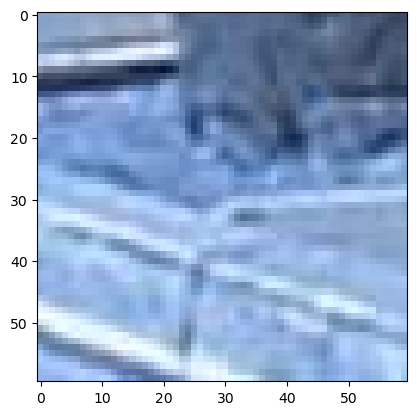

In [3]:
%matplotlib inline
plt.imshow(template)

In [4]:
class FeatureEx():
    def __init__(self,model,use_cuda=True):
        self.model=model[:17]
        self.use_cuda=use_cuda
# two features     
        self.feature1=None
        self.feature2=None
        if use_cuda:
            self.model.cuda()
#         using vgg19 pretrained weights on imageNet
#         we only use the 17 first layers (4 convolutions with pooling  and relu as an activation function)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model[2].register_module_forward_hook(self.saveFeature1)
        self.model[16].register_module_forward_hook(self.saveFeature2)
        
    
    def saveFeature1(self,model,inputs,outputs):
        self.feature1=model.detach(outputs)
    
    def saveFeature2(self,model,inputs,outputs):
        self.feature2=model.detach(outputs)
    
    def __call__(self,inputs,ft12=True):
        if self.use_cuda:
            inputs = inputs.cuda()
        self.model(inputs)
        if ft12:
#             we resize the second feature using bilinear interpolation
            self.feature2 = F.interpolate(self.feature2, size=(self.feature1.size()[2], self.feature1.size()[3]), mode='bilinear', align_corners=True)
        else:
            self.feature1 = F.interpolate(self.feature1, size=(self.feature2.size()[2], self.feature2.size()[3]), mode='bilinear', align_corners=True)
            
        
        return torch.cat((self.feature1, self.feature2), dim=1)        

In [5]:
class NormalisationLayer():
    def __call__(self, x1, x2):
        bs, _ , H, W = x1.size()
        _, _, h, w = x2.size()
        eps = 1e-12
        x1 = x1.view(bs, -1, H*W)
        x2 = x2.view(bs, -1, h*w)
        concat = torch.cat((x1, x2), dim=2)
        x_mean = torch.mean(concat, dim=2, keepdim=True)
        x_std = torch.std(concat, dim=2, keepdim=True)
        x1 = (x1 - x_mean) / (x_std + eps)
        x2 = (x2 - x_mean) / (x_std + eps)
        x1 = x1.view(bs, -1, H, W)
        x2 = x2.view(bs, -1, h, w)
        return [x1, x2]    

In [ ]:
class Qatm():
    def __init__(self,alpha):
        self.alpha=alpha
    def __call__(self,inputs):
        batch_size, ref_row, ref_col, qry_row, qry_col=inputs.size()
        inputs=inputs.view(batch_size, ref_row*ref_col, qry_row*qry_col)*self.alpha
        
        x_ref=inputs-torch.max(inputs,dim=1,keepdims=True)[0]
        x_qry=inputs-torch.max(inputs,dim=2,keepdims=True)[0]
        
        confRef=torch.nn.functional.softmax(x_ref)
        confTemp=torch.nn.functional.softmax(x_qry)
        
        confidence=torch.sqrt(confRef*confTemp)
        

In [ ]:
class CreateModel():
    def __init__(self,model,alpha,use_cuda=True):
        self.featureEx=FeatureEx(model,use_cuda)
        self.NormalisationLayer=NormalisationLayer()
        self.alpha=alpha
        self.imageFeature=None
        self.imageFeatureName=None
        
    def __call__(self,template,image,image_name):
        self.templateFeature=self.featureEx(template)
        if self.imageFeatureName is not image_name:
            self.imageFeature=self.featureEx(image)
            self.imageFeatureName=image_name
    ####
        imageFeature,templateFeature=self.NormalisationLayer(imageFeature,templateFeature)
    ### 
        self.imageFeature=torch.nn.functional.normalize(self.imageFeature, p=2.0, dim=1)
        self.templateFeature=torch.nn.functional.normalize(self.templateFeature, p=2.0, dim=1)
        
        inp=torch.einsum('xabc,xdec->xabde',self.imageFeature,self.templateFeature)
        
        
        
#         batchSizeTemp = self.templateFeature.size()[0]
        
#         for i in range(batchSizeTemp):
#             templateFeatureComp=torch.unsqueeze(templateFeature[i],dim=0)
#             imageFeatueComp=torch.unsqueeze(imageFeature[i],dim=0)
            
#              #normalisation
#             templateFeatureComp=torch.nn.functional.normalize(templateFeatureComp, p=2.0, dim=1)
#             imageFeatueComp=torch.nn.functional.normalize(imageFeatueComp, p=2.0, dim=1)

#             inp=torch.einsum('xabc,xdec->xabde',imageFeatueComp,templateFeatureComp)
            

In [ ]:
# torch.einsum('xabc,xdec->xabde',K.l2_normalize(x[0],axis=1),K.l2_normalize(x[1], axis=-1),name="cosine_dist")

In [39]:
a=torch.tensor([[[[1,1],[2,2]],[[3,3],[4,4]],[[5,5],[6,6]]],[[[1,3],[2,4]],[[3,3],[8,4]],[[5,7],[6,6]]]])
a=a.type(torch.DoubleTensor)
# a.size(),torch.nn.functional.normalize(a, p=2.0, dim=1)
# torch.nn.functional.normalize(a, p=2.0, dim=1),a/torch.norm(a, dim=1, keepdim=True)
val,_=torch.max(a, dim=1, keepdim=True)
val.size(),a.size()
inputs=a
batch_size, ref_row, ref_col, qry_row=inputs.size()
inputs=inputs.view(batch_size, ref_row*ref_col, qry_row)
x_ref=inputs-torch.max(inputs,dim=1,keepdims=True)[0]
x_qry=inputs-torch.max(inputs,dim=2,keepdims=True)[0]
confRef=torch.nn.functional.softmax(x_ref)
confTemp=torch.nn.functional.softmax(x_qry)
confRef,confTemp

C:\Users\yasmine\AppData\Local\Temp\ipykernel_9924\3160664121.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confRef=torch.nn.functional.softmax(x_ref)
C:\Users\yasmine\AppData\Local\Temp\ipykernel_9924\3160664121.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confTemp=torch.nn.functional.softmax(x_qry)


(tensor([[[0.8808, 0.2689],
          [0.8808, 0.2689],
          [0.8808, 0.7311],
          [0.1192, 0.7311],
          [0.8808, 0.2689],
          [0.8808, 0.7311]],
 
         [[0.1192, 0.7311],
          [0.1192, 0.7311],
          [0.1192, 0.2689],
          [0.8808, 0.2689],
          [0.1192, 0.7311],
          [0.1192, 0.2689]]], dtype=torch.float64),
 tensor([[[0.8808, 0.5000],
          [0.8808, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.9820],
          [0.8808, 0.5000],
          [0.5000, 0.5000]],
 
         [[0.1192, 0.5000],
          [0.1192, 0.5000],
          [0.5000, 0.5000],
          [0.5000, 0.0180],
          [0.1192, 0.5000],
          [0.5000, 0.5000]]], dtype=torch.float64))